In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [7]:
%matplotlib inline
import ipywidgets as widgets

In [358]:
boston_data = sm.datasets.get_rdataset('Boston', 'MASS').data
boston_data.loc[:, 'crim'] = np.log(boston_data['crim'])
boston_data.loc[:, 'lstat'] = np.log(boston_data['lstat'])
boston_data.loc[:, 'rm2'] = boston_data['rm'] ** 2
boston_data.loc[:, 'medv'] = np.log(boston_data.medv)

In [333]:
pd.DataFrame(np.round(boston_data.corr().loc[:,'medv'].drop('medv'), 2)).T

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,rm2
medv,-0.57,0.36,-0.54,0.16,-0.51,0.63,-0.45,0.34,-0.48,-0.56,-0.5,0.4,-0.82,0.64


In [222]:
boston_data.sample(5)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv,rm2
181,-2.675389,0.0,2.46,0,0.488,6.144,62.2,2.5979,3,193,17.8,396.90,2.246015,3.589059,37.748736
437,2.719794,0.0,18.10,0,0.740,6.152,100.0,1.9142,24,666,20.2,9.32,3.275256,2.163323,37.847104
44,-2.098094,0.0,6.91,0,0.448,6.069,40.0,5.7209,3,233,17.9,389.39,2.256541,3.054001,36.832761
252,-2.498478,22.0,5.86,0,0.431,6.957,6.8,8.9067,7,330,19.1,386.09,1.261298,3.387774,48.399849
339,-2.900968,0.0,5.19,0,0.515,5.985,45.4,4.8122,5,224,20.2,396.90,2.276241,2.944439,35.820225


<AxesSubplot:xlabel='medv', ylabel='Density'>

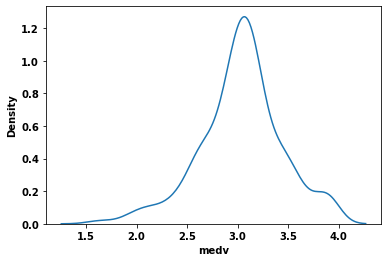

In [340]:
sns.kdeplot(boston_data.medv)

<AxesSubplot:xlabel='chas', ylabel='medv'>

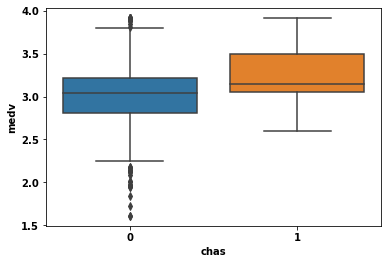

In [223]:
sns.boxplot(data=boston_data, x='chas', y='medv')

<AxesSubplot:xlabel='rm2', ylabel='Probability'>

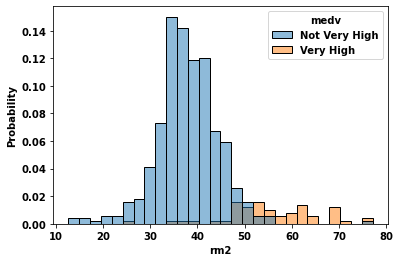

In [363]:
sns.histplot(data=boston_data, x='rm2', hue=(boston_data.medv>3.5).apply(lambda x: 'Very High' if x else 'Not Very High'), stat='probability')

In [361]:
@widgets.interact(col_nm=boston_data.columns)
def plot_col(col_nm):
    sns.histplot(data=boston_data, x=col_nm, hue=boston_data.medv>3.5, stat='probability')

interactive(children=(Dropdown(description='col_nm', options=('crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age…

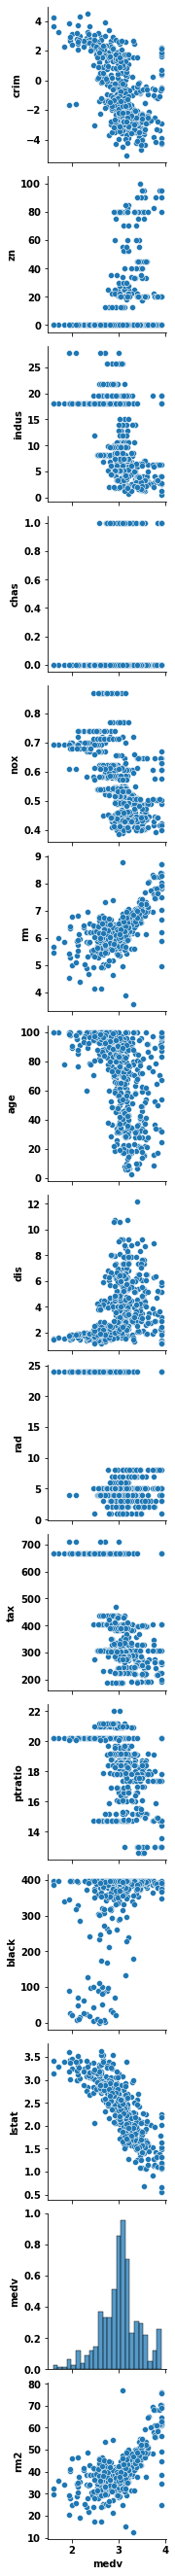

In [225]:
sns.pairplot(data=boston_data, x_vars=['medv'])

In [274]:
X = sm.add_constant(boston_data[['crim','zn','indus','chas','nox','rm','age','dis','rad','tax','lstat','rm2']])
y = boston_data['medv']

coords = {'obs_idx': X.index, 'feature_idx': X.columns}
with pm.Model(coords=coords) as model:
    _X = pm.Data('X', X)
    _y = pm.Data('y', y)

    beta = pm.Laplace('beta', mu=0, b=1/2, dims='feature_idx')
    lm_mu = pm.math.dot(_X, beta)

    var = pm.InverseGamma('var', alpha=1/2, beta=10/2)
    sigma = pm.Deterministic('sigma', pm.math.sqrt(var))
    # y_hat = pm.Cauchy('medv', alpha=lm_mu, beta=sigma, observed=_y)
    y_hat = pm.Normal('medv', mu=lm_mu, sigma=sigma, observed=_y)

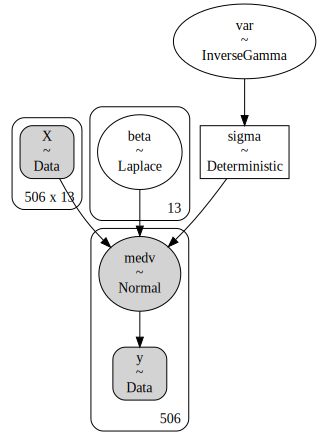

In [275]:
pm.model_to_graphviz(model)

In [276]:
with model:
    # res = pm.find_MAP()
    res = pm.sample(5000, tune=1000, chains=3, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [var, beta]


Sampling 3 chains for 1_000 tune and 5_000 draw iterations (3_000 + 15_000 draws total) took 224 seconds.
The acceptance probability does not match the target. It is 0.9098942569532108, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9144600825352048, but should be close to 0.8. Try to increase the number of tuning steps.


In [287]:
az.summary(res)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[const],5.042,0.514,4.077,5.996,0.006,0.005,6538.0,8499.0,1.0
beta[crim],-0.035,0.014,-0.061,-0.008,0.000,0.000,10124.0,10028.0,1.0
beta[zn],0.000,0.001,-0.001,0.001,0.000,0.000,11551.0,10888.0,1.0
beta[indus],0.001,0.003,-0.005,0.007,0.000,0.000,11321.0,10785.0,1.0
beta[chas],0.121,0.045,0.038,0.207,0.000,0.000,15417.0,11209.0,1.0
beta[nox],-0.184,0.183,-0.535,0.145,0.002,0.001,12037.0,11187.0,1.0
beta[rm],-0.320,0.158,-0.619,-0.029,0.002,0.001,5991.0,8091.0,1.0
beta[age],0.000,0.001,-0.001,0.002,0.000,0.000,13607.0,11809.0,1.0
beta[dis],-0.029,0.011,-0.049,-0.009,0.000,0.000,12283.0,11394.0,1.0
beta[rad],0.007,0.004,-0.000,0.014,0.000,0.000,8605.0,10052.0,1.0


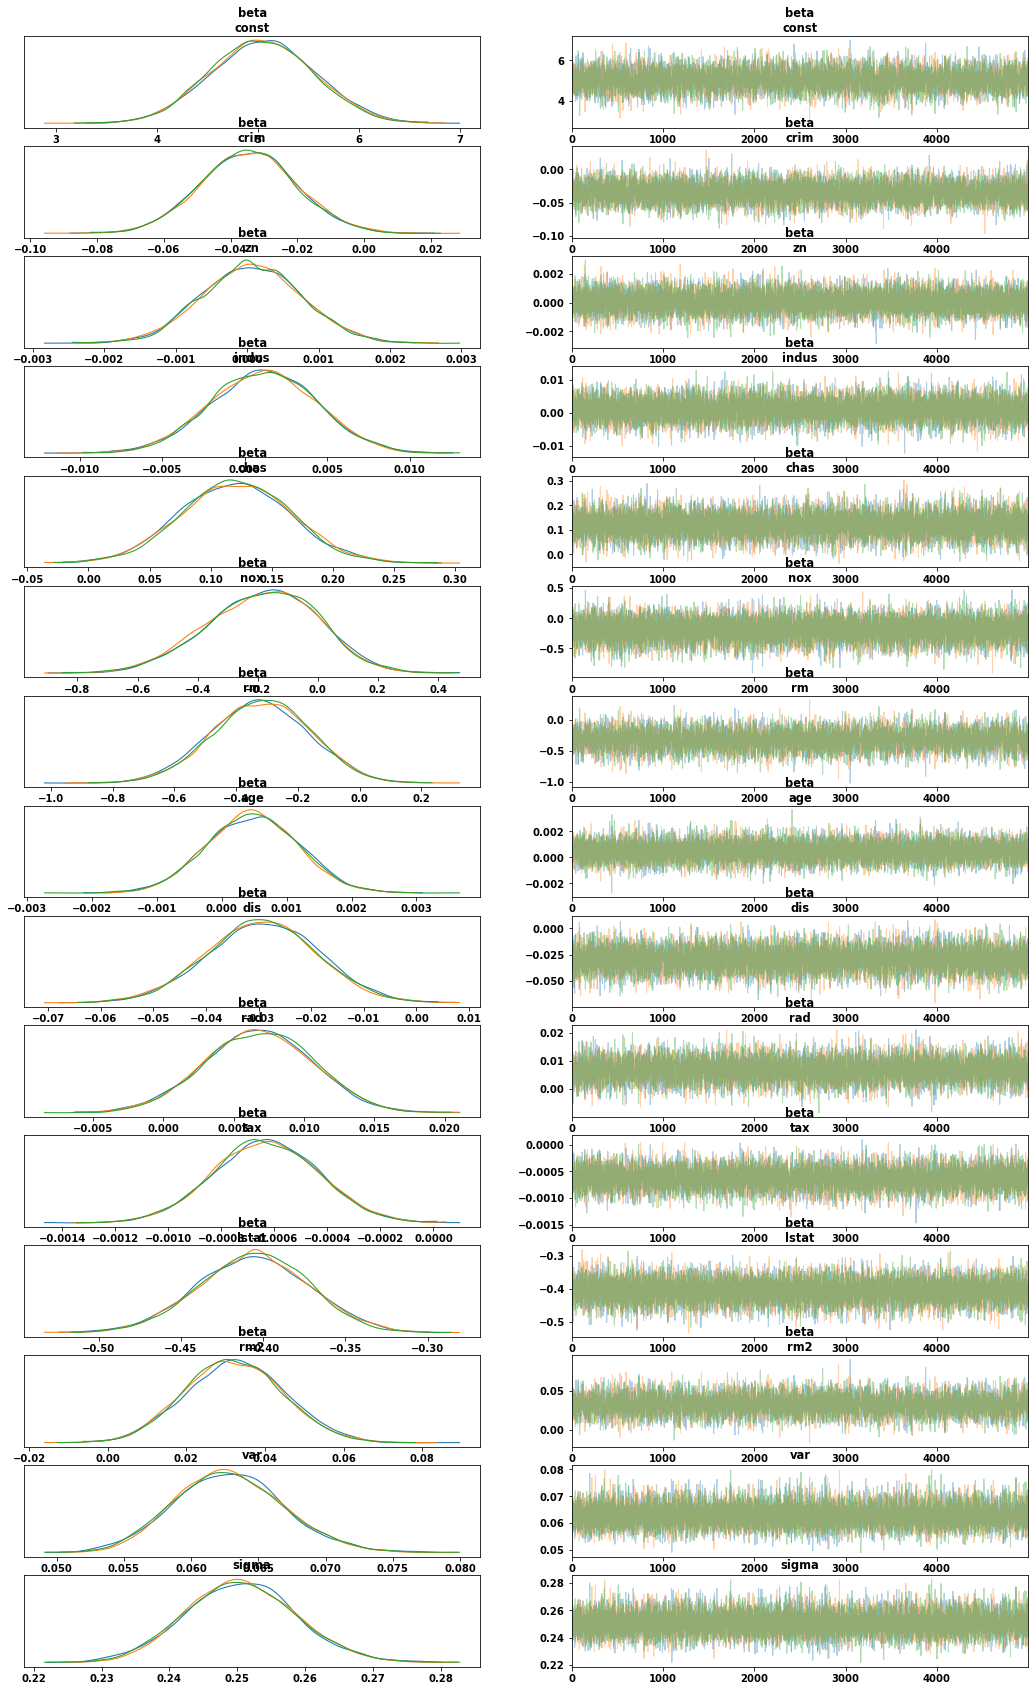

In [278]:
_ = az.plot_trace(res, compact=False, figsize=(18,30))

In [288]:
pm.loo(res, scale='deviance')

Computed from 15000 by 506 log-likelihood matrix

             Estimate       SE
deviance_loo  -111.23    35.04
p_loo           11.28        -

In [269]:
pm.loo(res, scale='deviance')

Computed from 15000 by 506 log-likelihood matrix

             Estimate       SE
deviance_loo  -113.37    35.25
p_loo           11.40        -

In [289]:
y_pred = X @ res.posterior.beta.mean(dim=['chain','draw']).to_pandas()

Text(0.5, 1.0, 'QQ Plot')

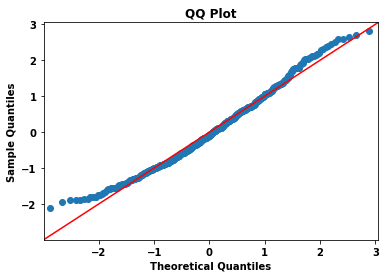

In [364]:
y_pred = pd.Series(y_pred, name='y_hat')
_ = sm.qqplot(y_pred, fit=True, line='45')
plt.title('QQ Plot')

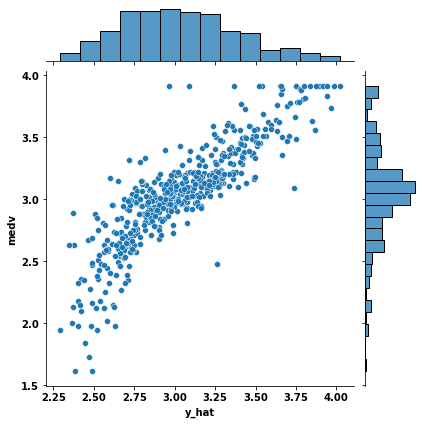

In [355]:
sns.jointplot(x=y_pred, y=y)

<AxesSubplot:xlabel='y_hat', ylabel='Density'>

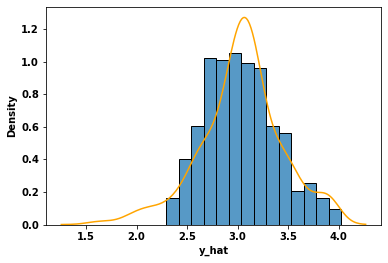

In [296]:
sns.histplot(y_pred, stat='density')
sns.kdeplot(y, color='orange')

<AxesSubplot:ylabel='Probability'>

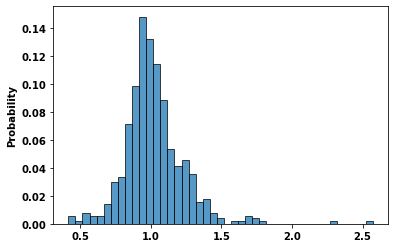

In [353]:
sns.histplot(np.exp(y-y_pred), stat='probability')


In [ ]:
with model:
    ppc = pm.sample_posterior_predictive(res)